# Notebook Estuaire for PIE 34

Short notebook to understand how grid and trajectories are generated for contrail avoidance project

In the future, we'll work only on Grid already generated

## Imports

In [3]:
#! pip install xarray --q
#! pip install pycontrails --q
#! pip install gcsfs --q
#! pip install h5netcdf --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.3 MB/s eta 0:00:00


To have access to data, run this notebook on Colab

In [7]:
import gcsfs
fs = gcsfs.GCSFileSystem()

from google.colab import auth
auth.authenticate_user()

In [5]:
import pandas as pd
import numpy as np

from pycontrails import Flight
from pycontrails.datalib.ecmwf import ERA5
from pycontrails.models.cocip import Cocip
from pycontrails.models.humidity_scaling import ConstantHumidityScaling, HistogramMatching
from pycontrails.models.ps_model import PSGrid,PSFlight
from pycontrails.physics import units

from pycontrails.core.met import MetDataArray, MetDataset
from pycontrails.models.cocipgrid import CocipGrid
import xarray as xr
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
import matplotlib.dates as mdates

## Access to flight trajectories

In [8]:
fp_df = pd.read_csv('gs://data_share_pie/flight_tracks_PIE.csv') #copy paste the path to the flight tracks
flight_id_list = fp_df.flight_id.unique()

In [31]:
flight_id_list #they are 6 flight tracks, you can play with them

array(['008b1d4a-fe25-4711-bcef-e96fbf8d6eaf',
       '8bde8cad-3cb3-4472-a1a1-241d3b8c765d',
       '99f87316-0987-4e83-8823-0762639d45c4',
       '28b36d36-d1fe-46cb-93db-e1e26ba84283',
       'bb42863b-b9ad-459d-8949-09a2e9724c19',
       'b9416a31-027b-4792-abec-190ba5f48760'], dtype=object)

In [9]:
index = 0 #first flight track is analysed

ft = fp_df[fp_df.flight_id == flight_id_list[index]].copy()

ft.head()

,UTC,icao_address,latitude,longitude,altitude,speed,direction,flight_id,timedeltas,vertical_speed,...,specific_humidity,u_wind,v_wind,rhi,true_airspeed,segment_length,sin_a,cos_a,aircraft_mass,fuel_flow
0,2023-01-07 20:32:40,345042,50.901960,4.482960,400.0,0.0,0.00000,008b1d4a-fe25-4711-bcef-e96fbf8d6eaf,0 days 00:00:15,0.0,...,0.006555,3.093240,7.778649,0.741433,8.446000,0.578234,-1.000000,0.000000,73391.680,1.085434
1,2023-01-07 20:32:55,345042,50.901955,4.482960,400.0,0.0,327.44217,008b1d4a-fe25-4711-bcef-e96fbf8d6eaf,0 days 00:00:15,0.0,...,0.006555,3.094865,7.776802,0.741372,8.351724,1.199074,0.500782,-0.865574,73375.400,1.080506
2,2023-01-07 20:33:10,345042,50.901960,4.482945,400.0,0.0,327.44217,008b1d4a-fe25-4711-bcef-e96fbf8d6eaf,0 days 00:00:15,0.0,...,0.006555,3.096488,7.774956,0.741312,8.219800,2.075989,0.968749,-0.248044,73359.190,1.073551
3,2023-01-07 20:33:25,345042,50.901978,4.482938,400.0,0.0,327.44217,008b1d4a-fe25-4711-bcef-e96fbf8d6eaf,0 days 00:00:15,0.0,...,0.006555,3.098114,7.773133,0.741253,8.324212,2.647973,-0.179974,0.983671,73343.086,1.079038
4,2023-01-07 20:33:40,345042,50.901974,4.482975,400.0,0.0,327.44217,008b1d4a-fe25-4711-bcef-e96fbf8d6eaf,0 days 00:00:15,0.0,...,0.006555,3.099745,7.771318,0.741188,8.731824,12.350365,-0.802829,-0.596209,73326.900,1.100038


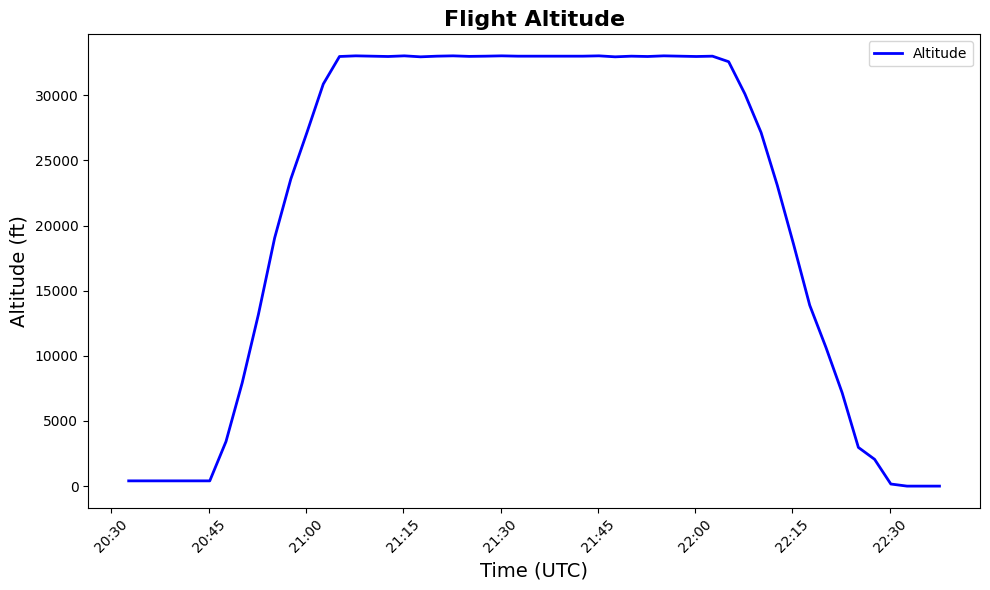

In [10]:
plt.figure(figsize=(10, 6))
ft['UTC'] = pd.to_datetime(ft['UTC'])
plt.plot(ft['UTC'][::10], ft['altitude'][::10], color='blue', linestyle='-', linewidth=2, label="Altitude")

plt.title("Flight Altitude", fontsize=16, fontweight='bold')
plt.xlabel("Time (UTC)", fontsize=14)
plt.ylabel("Altitude (ft)", fontsize=14)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.xticks(rotation=45)
plt.legend()

# Ajuster la disposition
plt.tight_layout()
plt.show()

## Import weather data

To import weather data, we download grib files from ERA5 `https://cds.climate.copernicus.eu` met and rad datasets from ERA5. They are essential for modeling contrail formation and environmental impact:

#### 1. `met` Dataset - ERA5 Hourly Data on Pressure Levels


Provides temperature, humidity, and wind profiles across altitudes, crucial for simulating contrail formation and persistence. Contrails need low temperatures and high humidity at flight levels to form and sustain.

#### 2. `rad` Dataset - ERA5 Hourly Data on Single Levels

Supplies radiation data (shortwave and longwave) to assess the contrails' warming or cooling effects. This dataset also includes cloud cover and albedo, allowing accurate modeling of contrail interactions with existing clouds and surfaces.

Together, these datasets allow pycontrails to simulate both the physical formation of contrails and their radiative impacts on the environment.

#### Parameters:

We need time bounds (`time`) and pressure levels (`pressure_levels`) to open properly the weather

In [11]:
time = (
    pd.to_datetime(ft["UTC"].iloc[0]).floor("h"),
    pd.to_datetime(ft["UTC"].iloc[-1]).ceil("h") + pd.Timedelta("10h"),
)

pressure_levels = [500, 450, 400, 350, 300, 250, 225, 200, 175, 150]

#### Import

In [21]:
fs = gcsfs.GCSFileSystem()


met_nc_path = 'gs://data_share_pie/met_input.nc'  # Chemin vers le fichier

try:
    f = fs.open(met_nc_path, 'rb')
    met_xr = xr.open_dataset(f, engine='h5netcdf')
    print("Dataset loaded successfully.")
except Exception as e:
    print("Error loading dataset:", e)



try:
    metpl = ERA5(time=time, variables=Cocip.met_variables + Cocip.optional_met_variables,
                              pressure_levels=pressure_levels)
    met = metpl.open_metdataset(dataset=met_xr)
except Exception as e:
    print("Error in opening metdataset:", e)

Dataset chargé avec succès.


In [18]:
rad_nc_path = 'gs://data_share_pie/rad_input.nc' #put path to met file

try:
    # Open file with xarray
    f = fs.open(rad_nc_path, 'rb')
    rad_xr = xr.open_dataset(f, engine='h5netcdf')  # or 'netcdf4'
    print("Dataset loaded successfully.")
except Exception as e:
    print("Error loading dataset:", e)

try:
    radpl = ERA5(time=time, variables=Cocip.rad_variables)
    rad = radpl.open_metdataset(dataset=rad_xr)  # Ensure you are passing the correct dataset
except Exception as e:
    print("Error in opening metdataset:", e)

Dataset loaded successfully.


## Generation of a contrail grid

to generate a whole contrail grid around the flight trajectory, we are using CocipGrid function from pycontrails. As an input, we need:

- a grid from a flight trajectory `ft` -> `grid`
    
- a `met` and `rad` dataset
    
- pressure levels -> `pressure_levels`
    
- parameters for contrail computation -> `params`

#### Creation of a grid

We create a MetDataset object as a grid by sampling the flight trajectory along longitude,latitude and pressurelevels

In [22]:
def create_grid(ft, levels):
    grid =  MetDataset.from_coords(
    level= levels,
    time=pd.date_range(ft.UTC.iloc[0], ft.UTC.iloc[-1]+pd.Timedelta(2,'h'),freq=pd.Timedelta(10,'m')),
    longitude=np.arange(ft.longitude.min(), ft.longitude.max(), 0.1),
    latitude=np.arange(ft.latitude.min(), ft.latitude.max(), 0.1),)

    return grid

In [23]:
grid = create_grid(ft, pressure_levels)

#### Cocip generation

In [24]:
params = {
            "aircraft_type": 'A321',
            "dt_integration": np.timedelta64(10, "m"),
            'max_age': np.timedelta64(6, 'h'),
            "humidity_scaling": HistogramMatching(interpolation_q_method="cubic-spline"),
            "interpolation_q_method": "cubic-spline",
            "interpolation_use_indices": True,
            "max_seg_length_m": 100000,
            'aircraft_performance': PSGrid()
        }

In [25]:
cocip = CocipGrid(met=met, rad=rad, params=params)
contrail_dataset = cocip.eval(source=grid)

CocipGrid eval:   0%|          | 0/175 [00:00<?, ?it/s]

Disclaimer: it's ok if the eval doesn't achived entirely!

The contrail grid is a Dataset with 2 Data variables along 4 coordinates (longitude, latitude, level, time):

- `contrail_age` : Total age in hours of persistent contrail
- `ef_per_` : Energy forcing per meter of flight trajectory in J/m

We'll be interested in `ef_per_m` to generate

In [26]:
contrail_dataset

MetDataset with data:

<xarray.Dataset> Size: 5MB
Dimensions:       (longitude: 25, latitude: 97, level: 10, time: 25)
Coordinates:
  * longitude     (longitude) float64 200B 2.068 2.168 2.268 ... 4.368 4.468
  * latitude      (latitude) float64 776B 41.29 41.39 41.49 ... 50.79 50.89
  * level         (level) float64 80B 150.0 175.0 200.0 ... 400.0 450.0 500.0
  * time          (time) datetime64[ns] 200B 2023-01-07T20:32:40 ... 2023-01-...
    air_pressure  (level) float32 40B 1.5e+04 1.75e+04 2e+04 ... 4.5e+04 5e+04
    altitude      (level) float32 40B 1.361e+04 1.263e+04 ... 5.574e+03
Data variables:
    contrail_age  (longitude, latitude, level, time) float32 2MB 0.0 0.0 ... 0.0
    ef_per_m      (longitude, latitude, level, time) float32 2MB 0.0 0.0 ... 0.0
Attributes: (12/13)
    humidity_scaling_name:     histogram_matching
    humidity_scaling_formula:  era5_quantiles -> iagos_quantiles
    azimuth:                   0.0
    segment_length:            1000.0
    met_source_provider:       ECMWF
    met_source_dataset:        ERA5
    ...                        ...
    aircraft_type:             A321
    description:               Gridded Contrail Cirrus Prediction Model
    max_age:                   6 hours
    dt_integration:            10 minutes
    pycontrails_version:       0.54.2
    ap_model:                  PSGrid

In [27]:
contrail_grid = contrail_dataset['ef_per_m']

## Plot contrail grid in 2D

Now, let's see if contrails are formed:

In this section, we **interpolate** the contrail grid just previously formed on the actual flight trajectory and **plot** the grid regarding altitude and time

To do so, we need firstly to create a Dataset with flight trajectory. We sample it by **10** in order to avoid a loo long interpolation (that can make the kernel crash!)

In [28]:
ft_sampled_xr = xr.Dataset({
            "latitude": ft['latitude'][::10].to_numpy(),
            "longitude": ft['longitude'][::10].to_numpy(),
            "altitude": ft['altitude'][::10].to_numpy(),
            "time": ft['UTC'][::10].to_numpy()
            })

We can now interpolate!

In [29]:
selected_values_heat = contrail_grid.data.interp(
    time=ft_sampled_xr['time'],
    latitude=ft_sampled_xr['latitude'],
    longitude=ft_sampled_xr['longitude'])

We can now plot it!

In [30]:
import plotly.graph_objects as go

RdBu_r_custom = [
[0.0, '#2166ac'],
[1/5, '#67a9cf'],
[2/5, '#d1e5f0'],
[0.5,'rgba(255,255,255,1)'],
[3/5,'#fddbc7'],
[4/5, '#ef8a62'],
[1.0, '#b2182b']
]


heat = np.array([selected_values_heat.data[i,i,:,i].tolist() for i in range (len(selected_values_heat.longitude.values))])

heatmap=go.Heatmap(x=selected_values_heat.time.values, y=units.m_to_ft(selected_values_heat.altitude.values), z=heat.T, colorscale=RdBu_r_custom,
    zmin=-1e9,
    zmax=1e9, colorbar_thickness=20,opacity=1,
    colorbar=dict(
        title=dict(text="Energy Forcing per distance (J/m)", side="right", font=dict(size=15,color='black')),
        tickvals=[-1e9, -0.5e9, 0, 0.5e9, 1e9],
        ticktext=["-1e9", "-0.5e9", "0", "0.5e9", "1e9"],
        tickfont=dict(color='black')  # Set colorbar tick labels to white
    ))

x0, x1 = pd.to_datetime(ft['UTC'].min()),pd.to_datetime(ft['UTC'].max())
delta = 0.03 * (x1 - x0)
layout = go.Layout(paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)',width=1000, height=600,
                title=dict(text=f"Flight altitude profile",xanchor="center",yanchor="top",x=0.45,y=0.88,font=dict(size=15,color='black')),
                xaxis=dict(title="Time (UTC)", gridcolor="black", gridwidth=0.5,linecolor="black",linewidth=2,ticks="outside",title_font=dict(color='black'), # Y-axis title color set to white
                            tickfont=dict(color='black')),
                yaxis=dict(title="Altitude (feet)", gridcolor="black", gridwidth=0.5,linecolor="black",linewidth=2,ticks="outside",title_font=dict(color='black'), # Y-axis title color set to white
                            tickfont=dict(color='black')),
                xaxis_range= [x0 - delta, x1 + delta],
                yaxis_range=[0,60000],
                showlegend=True,
                legend=dict(x=0.91, y=1.15, xanchor='center', yanchor='top',font=dict(size=15)))

flight_1 = go.Scatter(x=ft['UTC'], y=ft['altitude'], mode='lines', line=dict(color='black', width=3),name="Flight plan",showlegend=True)
fig = go.Figure(data = [heatmap, flight_1], layout = layout)
fig.show()